In [26]:
import pandas as pd
import scipy as sc
import altair as alt
import vega

alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

## Multi-armed bandits with Thompson sampling 

Fabio Schmidt-Fischbach

### Presentation on one slide: how to run experiments with many variants.  

Classical AB testing suffers from two problems. 
- Sample size : enormous sample requirements as # of variants grows. 
- Inefficiency : keep pushing users into variants that clearly underperform.

What is Thompson-sampling and how does it help us with testing? 
- Core idea: Don't waste samples on variants that are obviously underperforming.   
--> We are constantly updating our posteriors and allocate traffic according to them.    
--> "multi-armed bandit testing". 










### Which movie to recommend to our users? 


<img src="files/netflix.png">







### ...or in which gambling machine to throw your money in? 

<img src="files/bandits.jpeg">









### Problem description 

Setup: 
- N variants (e.g. slot machines, movies to recommend, landing pages...)
- each variant $i \in N$ has a reward $x_{i}$ which is unknown to us (e.g. different comms are more or less effective, some movies more or less popular and some slot machines return more or less money). 

Goal: 
- find the variant $i$ with the highest reward $x_{i}$ by experimentation: $ arg max_{i\in N} x_{i} $ 





### Solution of classical AB testing 

- split traffic equally/or at least at constant splits across your N objects 
- run the test either until sample size is reached (frequentist) or until you are confident enough in your results (Bayesian). 




### Simulation 

- Outcome: conversion - binomial data. 
- N = 6 (variants) 
- Rewards: $x_{0} = 0.20, x_{1} = 0.33, x_{2} = 0.35, x_{3} = 0.38, x_{4} = 0.34, x_{5} = 0.32$. 
- Testing approach: Bayesian (using beta priors for binomial data).



In [2]:
def success_probs_bayes(wins, losses, a_prior, b_prior, N):
    """
    Determine for various variants the probability that they are the best.
    wins = list of success observations for each variant.
    losses = list of loss observations for each variant.
    a_prior, b_prior : beta priors
    N = number of samples drawn from posterior to approximate Prob(variant is best)

    returns : list of length len(wins) with the probabilities that each variant is the best respectively.

    """
    from scipy.stats import beta
    import numpy as np

    np.random.seed(seed=1)

    if len(wins) != len(losses):
        raise ValueError("List length of wins and losses needs to be the same.")

    # draw N times from posteriors
    data = [
        [beta.rvs(wins[i] + a_prior, losses[i] + b_prior, size=N)]
        for i in range(len(wins))
    ]

    # evaluate which variant is the highest for each draw: this returns a list of length N with the index of the
    # highest sample
    variant, counts = np.unique(np.argmax(data, axis=0), return_counts=True)

    for v in range(len(wins)):
        if v not in variant:
            variant = np.insert(variant, v, v)
            counts = np.insert(counts, v, 0)

    # divide counts by total draws to get a probability.
    probs = counts / sum(counts)

    return probs

In [24]:
from scipy.stats import beta
import numpy as np

np.random.seed(1)
batches = 10

# vector with true rewards
x = [0.20, 0.33, 0.35, 0.38, 0.34, 0.32]

# generate conversions for each variant in batches of 1000 (max sample size is 1000 x 10 = 100 000)
wins = dict((i, np.random.binomial(1000, x[i], batches)) for i in range(len(x)))
# generate losses.
losses = dict((key, [1000 - sample for sample in items]) for key, items in wins.items())

d = dict()
for i in range(batches):
    # get cumulative data.
    wins_i = [sum(wins[n][0:i]) for n in range(len(x))]
    loss_i = [sum(losses[n][0:i]) for n in range(len(x))]

    d.update({i: success_probs_bayes(wins_i, loss_i, 1, 1, 10000)})


df = pd.DataFrame.from_dict(d, orient="index").fillna(0)
df["N"] = range(1, df.shape[0] + 1)

df = pd.melt(df, id_vars=["N"])

df["variant"] = df["variable"]

df["N"] = df["N"] * 1000

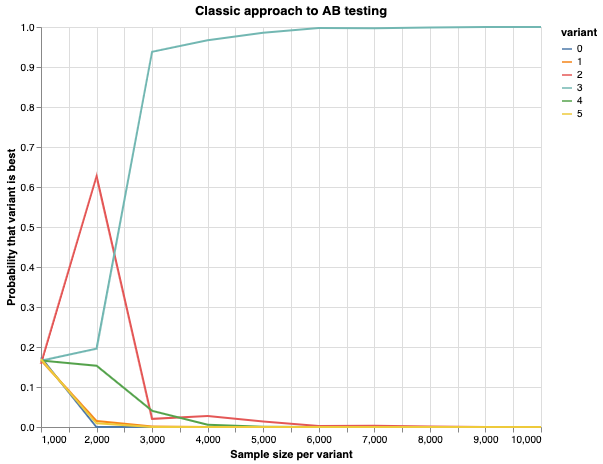

In [25]:
alt.Chart(df).mark_line().encode(
    x=alt.X("N:Q", axis=alt.Axis(title="Sample size per variant")),
    y=alt.Y("value:Q", axis=alt.Axis(title="Probability that variant is best")),
    color="variant:N",
).properties(width=500, height=400, title="Classic approach to AB testing")

In [27]:
from scipy.stats import beta
import numpy as np

np.random.seed(1)
batches = 10

# vector with true rewards
x = [0.30, 0.33, 0.35, 0.38, 0.34, 0.32]

# generate conversions for each variant in batches of 1000 (max sample size is 1000 x 10 = 100 000)
wins = dict((i, np.random.binomial(1000, x[i], batches)) for i in range(len(x)))
# generate losses.
losses = dict((key, [1000 - sample for sample in items]) for key, items in wins.items())

d = dict()
for i in range(batches):
    # get cumulative data.
    wins_i = [sum(wins[n][0:i]) for n in range(len(x))]
    loss_i = [sum(losses[n][0:i]) for n in range(len(x))]

    d.update({i: success_probs_bayes(wins_i, loss_i, 1, 1, 10000)})


df = pd.DataFrame.from_dict(d, orient="index").fillna(0)
df["N"] = range(1, df.shape[0] + 1)

df = pd.melt(df, id_vars=["N"])

df["variant"] = df["variable"] + 1

df["N"] = df["N"] * 1000 * len(x)

df = df.groupby(["N"])["value"].agg("max").reset_index()

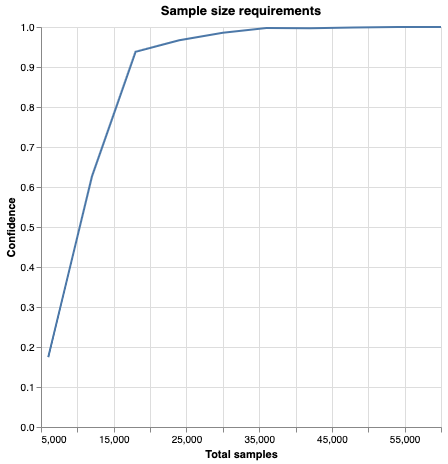

In [28]:
alt.Chart(df).mark_line().encode(
    x=alt.X("N:Q", axis=alt.Axis(title="Total samples")),
    y=alt.Y("value:Q", axis=alt.Axis(title="Confidence")),
).properties(width=400, height=400, title="Sample size requirements")

So, sample size is one topic. The other one is "regret"...

For each sample $j$ sent to variant $i$ define the regret as

$ E(regret_{i,j}) = ( x_{i} - arg max_{s \in N} x_{s} ) $

Example? The regret of sending a sample to variant 0 with $x_{0} = 0.20$ is $0.38-0.20=0.18$.


In [30]:
from scipy.stats import beta
import numpy as np

np.random.seed(1)
batches = 10

# vector with true rewards
x = [0.20, 0.33, 0.35, 0.38, 0.34, 0.32]

# generate conversions for each variant in batches of 1000 (max sample size is 1000 x 10 = 100 000)
wins = dict((i, np.random.binomial(1000, x[i], batches)) for i in range(len(x)))
# generate losses.
losses = dict((key, [1000 - sample for sample in items]) for key, items in wins.items())

d = dict()
for i in range(batches):
    # get cumulative data.
    wins_i = [sum(wins[n][0:i]) for n in range(len(x))]
    loss_i = [sum(losses[n][0:i]) for n in range(len(x))]

    d.update({i: success_probs_bayes(wins_i, loss_i, 1, 1, 10000)})


df = pd.DataFrame.from_dict(d, orient="index").fillna(0)
df["N"] = range(1, df.shape[0] + 1)

df = pd.melt(df, id_vars=["N"])

df["variant"] = df["variable"]

df["N"] = df["N"] * 1000

x_d = {}
for i in range(len(x)):
    x_d[i] = x[i]

x_d = pd.DataFrame.from_dict(x_d, orient="index", columns=["conversion"]).reset_index()

df = df.merge(x_d, left_on=["variant"], right_on=["index"], how="left").reset_index()

df["best_c"] = max(df["conversion"])
df["regret"] = df["best_c"] - df["conversion"]
df["total_regret"] = df["N"] * df["regret"]

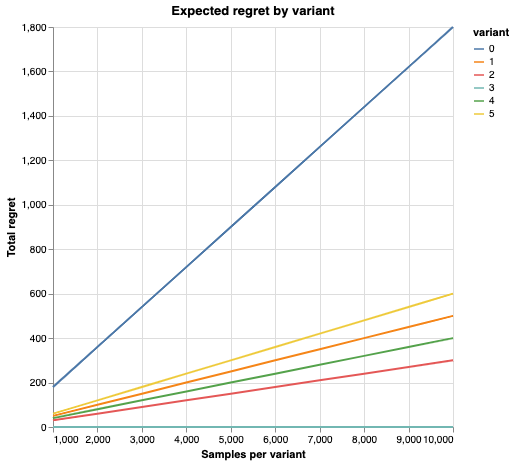

In [31]:
alt.Chart(df).mark_line().encode(
    x=alt.X("N:Q", axis=alt.Axis(title="Samples per variant")),
    y=alt.Y("total_regret:Q", axis=alt.Axis(title="Total regret")),
    color="variant:N",
).properties(width=400, height=400, title="Expected regret by variant")

In [32]:
from scipy.stats import beta
import numpy as np

np.random.seed(1)
batches = 10

# vector with true rewards
x = [0.20, 0.33, 0.35, 0.38, 0.34, 0.32]

# generate conversions for each variant in batches of 1000 (max sample size is 1000 x 10 = 100 000)
wins = dict((i, np.random.binomial(1000, x[i], batches)) for i in range(len(x)))
# generate losses.
losses = dict((key, [1000 - sample for sample in items]) for key, items in wins.items())

d = dict()
for i in range(batches):
    # get cumulative data.
    wins_i = [sum(wins[n][0:i]) for n in range(len(x))]
    loss_i = [sum(losses[n][0:i]) for n in range(len(x))]

    d.update({i: success_probs_bayes(wins_i, loss_i, 1, 1, 10000)})


df = pd.DataFrame.from_dict(d, orient="index").fillna(0)
df["N"] = range(1, df.shape[0] + 1)

df = pd.melt(df, id_vars=["N"])

df["variant"] = df["variable"]

df["N"] = df["N"] * 1000 * len(x)

x_d = {}
for i in range(len(x)):
    x_d[i] = x[i]

x_d = pd.DataFrame.from_dict(x_d, orient="index", columns=["conversion"]).reset_index()

df = df.merge(x_d, left_on=["variant"], right_on=["index"], how="left").reset_index()

df["best_c"] = max(df["conversion"])
df["regret"] = df["best_c"] - df["conversion"]
df["total_regret"] = df["N"] * df["regret"]

df = df.groupby(["variant"])["total_regret"].agg("sum").reset_index()

In [11]:
regret_classic = (
    alt.Chart(df)
    .mark_bar()
    .encode(
        x=alt.X("variant:N", axis=alt.Axis(title="Variant")),
        y=alt.Y("total_regret:Q", axis=alt.Axis(title="Total regret")),
    )
    .properties(
        width=300,
        height=500,
        title="Expected total regret by variant with classical sampling",
    )
)

### Multi-armed bandits : an alternative approach to multi-variant testing.

Main idea: avoid sending samples to clearly underperforming variants.

In the jargon of the field, let's move towards exploitation rather than pure exploration. 

--> One example algorithm. Thompson sampling. 


### Thompson sampling : algorithm 

1. Before each observation decide what variant this user will see
    - Thompson sampling: sample one value from each variant-posterior. The next user will see the variant with the highest draw in this round.
2. Wait for the reward to realize 
3. Update the posterior of the chosen variant according to the realization in step (2). 
4. Evaluate how confident you are in your results (can we stop yet?) and if not continue at (1). 
















In [33]:
from scipy.stats import beta

unexplored = beta.rvs(1, 1, size=100000)
explored_good = beta.rvs(30, 70, size=100000)
explored_medium = beta.rvs(20, 80, size=100000)
explored_bad = beta.rvs(5, 95, size=100000)

df = pd.DataFrame(unexplored, columns=["unexplored"])
df["explored_good"] = explored_good
df["explored_bad"] = explored_bad

df = pd.melt(df)

df["value"] = df["value"].round(3)
df["x"] = 1
df = df.groupby(["variable", "value"])["x"].agg("count").reset_index()

df["perc"] = 100 * df["x"] / df.groupby(["variable"])["x"].transform("sum")

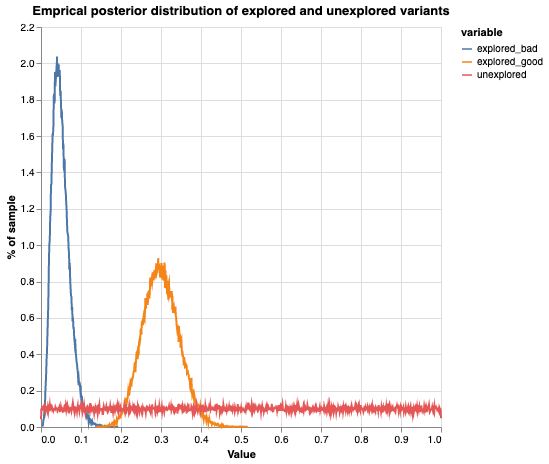

In [34]:
alt.Chart(df).mark_line().encode(
    x=alt.X("value:Q", axis=alt.Axis(title="Value")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of sample")),
    color="variable:N",
).properties(
    width=400,
    height=400,
    title="Emprical posterior distribution of explored and unexplored variants",
)

In [14]:
def decide_next_variant(posteriors):
    """
    Function that takes as input a list of N lists with 2 respective values.
    outputs a number between 1 and N to decide which variant will be seen by the next user.
    input: list of lists
    returns : int
    """

    # draw N values from the respective posteriors.

    draws = [beta.rvs(posterior[0], posterior[1], size=1) for posterior in posteriors]

    # determine best candidate

    next_variant = np.argmax(draws, axis=0)

    return int(next_variant)

In [15]:
def update_posterior(variant, posteriors, success):
    """
    Updates the posterior of variant out of the list of posteriors according to result

    variant : integer from 0 to N.
    posteriors: list of N length 2 lists with current posterior parameters.
    success : True if last observation was a success, else False

    returns: updated posteriors as list of lists.
    """

    if success == True:
        new_value = [posteriors[variant][0] + 1, posteriors[variant][1]]
        posteriors[variant] = new_value
    else:
        new_value = [posteriors[variant][0], posteriors[variant][1] + 1]
        posteriors[variant] = new_value

    return posteriors

In [16]:
def evaluate_confidence(posteriors, N):
    """
    Checks whether we can already stop the experiment by sampling N times from posteriors
    and checking how often one variant returns the highest value.

    returns: max confidence in either of the variants.
    """
    from scipy.stats import beta
    import numpy as np

    # draw N times from posteriors
    data = [[beta.rvs(posterior[0], posterior[1], size=N)] for posterior in posteriors]

    # evaluate which variant is the highest for each draw: this returns a list of length N with the index of the
    # highest sample
    variant, counts = np.unique(np.argmax(data, axis=0), return_counts=True)

    for v in range(len(wins)):
        if v not in variant:
            variant = np.insert(variant, v, v)
            counts = np.insert(counts, v, 0)

    # divide counts by total draws to get a probability.
    probs = counts / sum(counts)

    return max(probs)

In [42]:
from scipy.stats import bernoulli

# vector with true rewards
x = [0.20, 0.33, 0.35, 0.38, 0.34, 0.32]

# initiate posteriors
start = [1, 1]
posteriors = [start for i in range(len(x))]

# max sample size
max_sample = 100000

# store records of experiment in dictionary.
results = {}

for user in range(max_sample):
    next_variant = decide_next_variant(posteriors)
    # see whether it's a success or not: a single draw from the respective bernuolli.
    success = bernoulli.rvs(x[next_variant], size=1) == 1
    # update posterior
    posteriors = update_posterior(next_variant, posteriors, success)

    if evaluate_confidence(posteriors, 10000) >= 0.95:
        break

    # store every 100th step in results
    if user % 100 == 0:
        results[user] = posteriors.copy()

In [43]:
# create samples by step and variant
df = dict(
    (key, [variant[0] + variant[1] for variant in item])
    for key, item in results.items()
)
df = pd.DataFrame.from_dict(df, orient="index").reset_index()
df = pd.melt(df, id_vars=["index"])

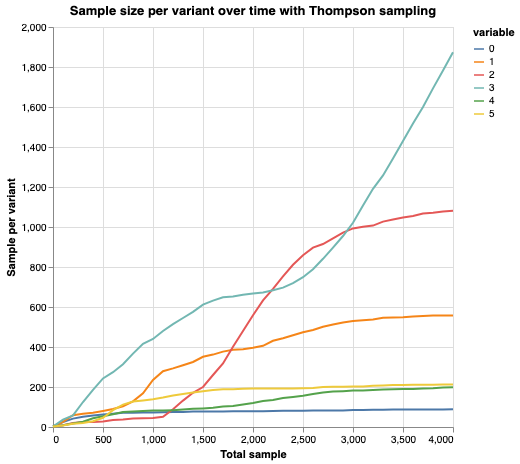

In [44]:
alt.Chart(df).mark_line().encode(
    x=alt.X("index:Q", axis=alt.Axis(title="Total sample")),
    y=alt.Y("value:Q", axis=alt.Axis(title="Sample per variant")),
    color="variable:N",
).properties(
    width=400,
    height=400,
    title="Sample size per variant over time with Thompson sampling",
)

In [45]:
# create samples by step and variant
df = dict(
    (key, [variant[0] + variant[1] for variant in item])
    for key, item in results.items()
)
df = pd.DataFrame.from_dict(df, orient="index").reset_index()
df = pd.melt(df, id_vars=["index"])

x_d = {}
for i in range(len(x)):
    x_d[i] = x[i]

x_d = pd.DataFrame.from_dict(x_d, orient="index", columns=["conversion"]).reset_index()

df = df.merge(x_d, left_on=["variable"], right_on=["index"], how="left").reset_index()

df["best_c"] = max(df["conversion"])
df["regret"] = df["best_c"] - df["conversion"]
df["total_regret"] = df["value"] * df["regret"]

df = df.groupby(["variable"])["total_regret"].agg("sum").reset_index()

In [46]:
regret_thompson = (
    alt.Chart(df)
    .mark_bar()
    .encode(
        x=alt.X("variable:N", axis=alt.Axis(title="Variant")),
        y=alt.Y(
            "total_regret:Q", axis=alt.Axis(title="Total regret"), scale=alt.Scale()
        ),
    )
    .properties(
        width=300,
        height=500,
        title="Expected total regret by variant with Thompson sampling",
    )
)

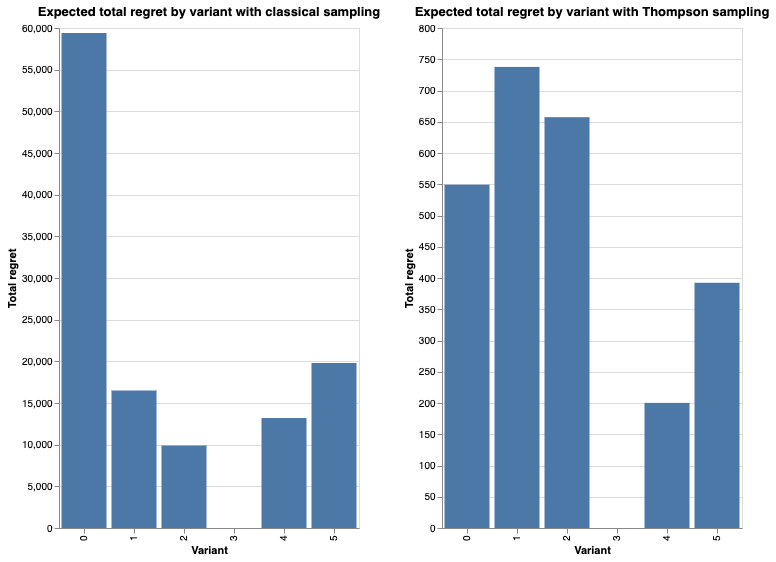

In [47]:
regret_classic | regret_thompson

### Summary

- Thompson sampling can be both faster and reduce the losses you make by pushing less traffic to "obviously bad variants". 
- Thompson sampling most likely will have more false positives. At least, other's simulation suggest this. 

When to use it? 
- If you have a large set of variants to test this is most likely the way to go. 
- Recommendation systems that condition the variant on a vector X of (user/time characteristics) you use bandits as well (contextual bandits). 

